Classification of diseases by symptoms

#Import библиотек

In [0]:
from google.colab import files #модуль для загрузки файлов в colab
import numpy as np #библиотека для работы с массивами данных
import pandas as pd #библиотека для обработки и анализа данных
import matplotlib.pyplot as plt #библиотека для визуализации данных
import re
# "Магическая"команда python для запуска библиотеки в ноутбуке
%matplotlib inline

from collections import Counter

from tensorflow.keras import utils #модуль с утилитами кераса, будем использовать для вызова метода преобразования категорий в вектора

from tensorflow.keras.models import Sequential #последовательная модель нейросети кераса
# Загружаем стандартные слои нейросети(полносвязный, регуляризации, нормализации, векторного представления слов, выравнивания, активации)
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
# Загружаем сверточные слои
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
# Загружаем рекуррентные слои
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, CuDNNLSTM, CuDNNGRU, Bidirectional

from tensorflow.python.keras.optimizers import Adam, RMSprop #загружаем алгоритмы обучения/оптимизации
from tensorflow.keras.preprocessing.sequence import pad_sequences #метод для формирования последовательностей одинаковой длины

from sklearn.preprocessing import LabelEncoder #класс кодирования категории в числа
from keras.preprocessing.text import Tokenizer, text_to_word_sequence #инструменты предобработки текста от кераса
from sklearn.model_selection import train_test_split #модуль для разбиения данных на обучающую и тестовую выборки

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


##Загрузка данных



In [0]:
# Загрузка данных
# Функция чтения текста из файла с симптомами
def read_only_text(fileName):
  f = open(fileName, 'r')
  text = f.read()
  return text

# Функция разбивающая текст на абзацы и удаляющая переносы строки в абзацах
def split_abzac(text):
  clean_abzacs = []
  # Делим текст на абзацы по признаку "Двойной перенос строки"
  abzacs = re.split("\x0a\x0a", text)
  # Удаляем переносы строк в абзаце
  for cur_abzac in abzacs:
    cur_abzac = cur_abzac.replace("\n", " ")
    clean_abzacs.append(cur_abzac)
    #print(cur_abzac)
  return clean_abzacs

#  Создаем DataFrame куда поместим все описания заболеваний разбитые на абзацы и их класс 
columns = ['describe', 'category']
df_all = pd.DataFrame(columns=columns)

#Задаем класс заболевания - они же имена файлов с описаниями симптомов
className = ["Аппендицит","Гастрит","Гепатит","Дуоденит","Колит","Панкреатит","Халицестит","Эзофагит","Энтерит","Язва"]
nClasses = len(className)

# Считываем тексты 
for name in className:  
  cur_text = read_only_text('/content/drive/My Drive/Базы/Болезни/'+name+'.txt')
  splited_text = split_abzac(cur_text)
  print(name, 'кол-во абзацев = ',len(splited_text))

  # Запись абзаца с симптомом и категории к котой он относится
  df_cur_text = pd.DataFrame(columns)
  df_cur_text = pd.DataFrame(splited_text)
  df_cur_text['category'] = name
  df_cur_text.columns = columns
  df_all = df_all.append(df_cur_text)
#  print(df_cur_text)

df_all.reset_index(inplace = True, drop = True)
df_all = df_all.loc[df_all['describe'] != '']
print(df_all.head(5))
print(df_all.tail(5))

print(df_all.shape)

Аппендицит кол-во абзацев =  25
Гастрит кол-во абзацев =  15
Гепатит кол-во абзацев =  27
Дуоденит кол-во абзацев =  25
Колит кол-во абзацев =  46
Панкреатит кол-во абзацев =  33
Халицестит кол-во абзацев =  24
Эзофагит кол-во абзацев =  34
Энтерит кол-во абзацев =  19
Язва кол-во абзацев =  22
                                            describe    category
0  Резкая боль в животе Повышение температуры Нап...  Аппендицит
1  Острая боль в животе, в том числе и при надавл...  Аппендицит
2  Тупая боль возле пупка или верхней части живот...  Аппендицит
3  Тупя или острая боль в верхней или нижней част...  Аппендицит
4  Боль в животе, сначала в эпигастральной област...  Аппендицит
                                              describe category
264  появление отрыжки после приема пищи раннее поя...     Язва
265   боль,которая возникает через час после еды и ...     Язва
266  колющая,давящая боль или рези в области желудк...     Язва
267  Тошнота, иногда сопровождающаяся рвотой.   Изж...    

In [0]:
#################
# Задаем данные
#################
texts = df_all['describe'].values              #извлекаем данные всех текстов из столбца text
classes = list(df_all['category'].values)  #извлекаем соответствующие им значения классов(лейблов) столбца text
maxWordsCount = 50000                  #зададим макс.кол-во слов/индексов, учитываемое при обучении текстов


list_unic_classes = df_all['category'].unique()
print(list_unic_classes)         #выводим все уникальные значения классов
nClasses = df_all['category'].nunique()  #задаём количество классов, обращаясь к столбцу category и оставляя уникальные значения
print(nClasses) #взглянем на количество классов

['Аппендицит' 'Гастрит' 'Гепатит' 'Дуоденит' 'Колит' 'Панкреатит'
 'Халицестит' 'Эзофагит' 'Энтерит' 'Язва']
10


In [0]:
# преобразовать слова в числа

#определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
maxWordsCount = 2000

# нам поможет Tokenizer
tokenizer = Tokenizer(
    num_words=maxWordsCount, 
    filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\r\xa0', 
    lower=True, split=' ', oov_token='unknown', char_level=False
)
# собственно скармливаем тексты для сборки словаря частотности
tokenizer.fit_on_texts(texts)
# вытаскиваем индексы слов для просмотра
items = list(tokenizer.word_index.items())

print("Размер словаря", len(items))
print(items[:10])
print(items[-10:])

Размер словаря 1992
[('unknown', 1), ('в', 2), ('и', 3), ('боль', 4), ('тошнота', 5), ('или', 6), ('рвота', 7), ('боли', 8), ('живота', 9), ('при', 10)]
[('колющая', 1983), ('давящая', 1984), ('рези', 1985), ('почти', 1986), ('возникновения', 1987), ('связаны', 1988), ('надчревной', 1989), ('заброс', 1990), ('кисловатый', 1991), ('горьковатый', 1992)]


In [0]:
items[0]

('unknown', 1)

In [0]:
#преобразовываем текст в последовательность индексов согласно частотному словарю
texts_in_WordIndexes = tokenizer.texts_to_sequences(texts) #обучающие тесты в индексы

print(len(texts))
print(len(texts_in_WordIndexes))

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", texts[0] [:86])
print("Он же в виде последовательности индексов: ", texts_in_WordIndexes[0][:20])

254
254
Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               Резкая боль в животе Повышение температуры Напряженность мышц Тошнота
Он же в виде последовательности индексов:  [97, 4, 2, 11, 25, 26, 873, 213, 5]


In [0]:
print("Статистика по обучающим текстам:")

sW_all=0
sS_all=0
sA_all=0
for cur_class in list_unic_classes  :
  sW=0
  sS=0
  sA=0
  for i in range(len(texts)):
    if cur_class == classes[i]:
      sA += 1                        # абзацы
      sS += len(texts[i])            # символы
      sW += len(texts_in_WordIndexes[i]) # слова

  print(cur_class, " ", sA, 'абзацев ', sS, " символов, ", sW, " слов")
  sW_all += sW
  sS_all += sS
  sA_all += sA
print()
print("В сумме ", sA_all, 'абзацев ',sS_all, " символов, ", sW_all, " слов")

Статистика по обучающим текстам:
Аппендицит   22 абзацев  4027  символов,  579  слов
Гастрит   15 абзацев  6689  символов,  839  слов
Гепатит   24 абзацев  5471  символов,  687  слов
Дуоденит   24 абзацев  3893  символов,  488  слов
Колит   44 абзацев  9037  символов,  1192  слов
Панкреатит   31 абзацев  11249  символов,  1480  слов
Халицестит   23 абзацев  6111  символов,  841  слов
Эзофагит   32 абзацев  5801  символов,  793  слов
Энтерит   18 абзацев  6347  символов,  828  слов
Язва   21 абзацев  3418  символов,  472  слов

В сумме  254 абзацев  62043  символов,  8199  слов


# Деление текста в абзацах на отрезки

In [0]:
#Задаём базовые параметры для разбиения абзацев на отрезки
xLen = 50 #Длина отрезка текста, по которой анализируем, в словах
step = 1 #Шаг разбиения исходного текста на обучающие вектора

In [0]:
# Функция деления вектора сообщения на отрезки (разделение на короткие векторы)
# возвращает список раскусаных сообщений
def split_message(wordIndexes, xLen, step):
  xSample = []
  index = 0
  
  #print(wordIndexes)

  #Добиваем длинну индексов до размера отрезка
  while len(wordIndexes) < xLen:
    wordIndexes = [1] + wordIndexes
    #print(len(wordIndexes), wordIndexes)
  #Идём по всей длине вектора индексов
  #"Откусываем" векторы длины xLen и смещаеммся вперёд на step
  while (index + xLen <= len(wordIndexes)):
    #print(index, wordIndexes[index:index+xLen])
    xSample.append(wordIndexes[index:index+xLen])    
    index += step
  #print(len(xSample)) 
  return xSample

In [0]:
wordIndexes_ = [97, 4, 2, 11, 25, 26, 873, 213, 5]
print(split_message(wordIndexes_, xLen, step))

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 97, 4, 2, 11, 25, 26, 873, 213, 5]]


In [0]:
# Формируем новую базу из раскусанных кусков сообщений
split_texts_WI = []
split_class_WI = []

for num in range(len(texts_in_WordIndexes)):
  list_cur_class = []
  if len(texts_in_WordIndexes[num]) > 0:
    spl_mes = split_message(texts_in_WordIndexes[num], xLen, step)
    print('Абзац № ', num, 'в нем слов = ', len(texts_in_WordIndexes[num]), 'разбито на отрезков = ', len(spl_mes))
    # добавляем к общему списку раскусанные сообщения
    split_texts_WI.extend(spl_mes)
    # формируем равноразмерный список со значением класса для списка раскусанных сообщений
    for i in range(len(spl_mes)): 
      list_cur_class.append(classes[num])
    split_class_WI.extend(list_cur_class)

print(len(split_texts_WI))
print(len(split_class_WI))

Абзац №  0 в нем слов =  9 разбито на отрезков =  1
Абзац №  1 в нем слов =  14 разбито на отрезков =  1
Абзац №  2 в нем слов =  40 разбито на отрезков =  1
Абзац №  3 в нем слов =  25 разбито на отрезков =  1
Абзац №  4 в нем слов =  41 разбито на отрезков =  1
Абзац №  5 в нем слов =  10 разбито на отрезков =  1
Абзац №  6 в нем слов =  59 разбито на отрезков =  10
Абзац №  7 в нем слов =  10 разбито на отрезков =  1
Абзац №  8 в нем слов =  26 разбито на отрезков =  1
Абзац №  9 в нем слов =  34 разбито на отрезков =  1
Абзац №  10 в нем слов =  32 разбито на отрезков =  1
Абзац №  11 в нем слов =  14 разбито на отрезков =  1
Абзац №  12 в нем слов =  27 разбито на отрезков =  1
Абзац №  13 в нем слов =  15 разбито на отрезков =  1
Абзац №  14 в нем слов =  8 разбито на отрезков =  1
Абзац №  15 в нем слов =  75 разбито на отрезков =  26
Абзац №  16 в нем слов =  60 разбито на отрезков =  11
Абзац №  17 в нем слов =  30 разбито на отрезков =  1
Абзац №  18 в нем слов =  19 разбито 

In [0]:
# преобразуем назад векторы индексов в текстовые сообщения
split_texts = []

items = list(tokenizer.word_index.items())

for num in range(len(split_texts_WI)):
  cur_text = split_texts_WI[num]
  cur_mes = []
  for i in cur_text:
    char = items[i-1][0]
    cur_mes.append(char)
  split_texts.append(cur_mes)
print(len(split_texts))
print(split_texts[0])

1797
['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'резкая', 'боль', 'в', 'животе', 'повышение', 'температуры', 'напряженность', 'мышц', 'тошнота']


In [0]:
#################
#преобразовываем категории в вектора
#################
encoder = LabelEncoder() #вызываем метод кодирования тестовых лейблов из библиотеки sklearn
encoder.fit(split_class_WI)     #подгружаем в него категории из нашей базы
classesEncoded = encoder.transform(split_class_WI)           #кодируем категории
split_class = utils.to_categorical(classesEncoded, nClasses) #и выводим каждый лейбл в виде вектора длиной 10, с 1кой в позиции соответсвующего класса и нулями
print(split_class.shape)  #взглянем на форму лейблов категорий
print(split_class[0])     #и отдельно на первую строку

(1797, 10)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# Создание обучающей и проверочной выборки

In [0]:
# Для Эмбэддинга представляем текст в виде последовательности индексов слов, каждый из которых затем преобразуем в многомерный вектор
Sequences = tokenizer.texts_to_sequences(split_texts)  #разбиваем текст на последовательность индексов
npSequences = np.array(Sequences)                #переведём в массив numpy
xTrainE, xValE, yTrainE, yValE = train_test_split(npSequences, split_class, test_size=0.2) #сформируем новую форму выборки
print(xTrainE.shape) #взглянем на форму текстов из обучающей выборки
print(np.array(yTrainE).shape)  #и на форму соответствующих им классов
print(xValE.shape) #взглянем на форму текстов из обучающей выборки
print(np.array(yValE).shape)  #и на форму соответствующих им классов

(1437, 50)
(1437, 10)
(360, 50)
(360, 10)


In [0]:
num = 150
print(xTrainE[num])
print(yTrainE[num])

[  5 279 104  17  16  48  54   2 280   4   2  11  97 432   6  83 433   5
  83   6 952  70 346 281  12  28  20  14  15  86 339 605   7   2 616 617
 338 340   7  15 190 446  33   2 280  22 953 618 282  69]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


##Нейросеть

**Embedding + Dense**

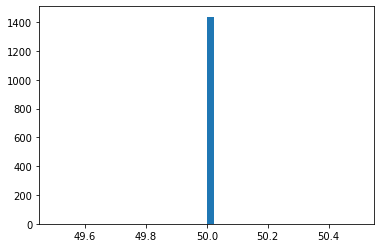

In [0]:
# Построим гистограмму для визуализации длины текста
lenXTrainE = [len(x) for x in xTrainE]
plt.hist(lenXTrainE, 40)
plt.show()

Train on 1437 samples, validate on 360 samples
Epoch 1/50
1437/1437 [==============================] - 4s 3ms/sample - loss: 1.8935 - acc: 0.4092 - val_loss: 1.2062 - val_acc: 0.7222
Epoch 2/50
1437/1437 [==============================] - 2s 1ms/sample - loss: 0.6503 - acc: 0.8003 - val_loss: 0.6495 - val_acc: 0.8361
Epoch 3/50
1437/1437 [==============================] - 2s 1ms/sample - loss: 0.4727 - acc: 0.8643 - val_loss: 0.4284 - val_acc: 0.8694
Epoch 4/50
1437/1437 [==============================] - 2s 1ms/sample - loss: 0.3553 - acc: 0.9047 - val_loss: 0.3528 - val_acc: 0.8944
Epoch 5/50
1437/1437 [==============================] - 2s 1ms/sample - loss: 0.2682 - acc: 0.9290 - val_loss: 0.4061 - val_acc: 0.8861
Epoch 6/50
1437/1437 [==============================] - 2s 1ms/sample - loss: 0.2330 - acc: 0.9318 - val_loss: 0.3491 - val_acc: 0.8889
Epoch 7/50
1437/1437 [==============================] - 2s 1ms/sample - loss: 0.2182 - acc: 0.9381 - val_loss: 0.3337 - val_acc: 0.8917
E

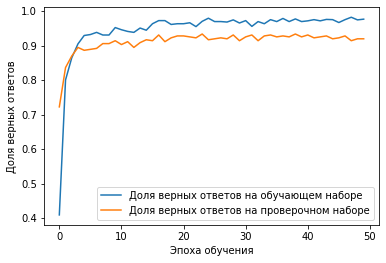

In [0]:
modelE = Sequential() #создаём последовательную модель нейросети

#преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelE.add(Embedding(maxWordsCount, 50, input_length=xLen))

modelE.add(SpatialDropout1D(0.1)) #добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelE.add(Flatten()) #добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
modelE.add(BatchNormalization()) #добавляем слой нормализации данных
modelE.add(Dense(100, activation="relu")) #добавляем полносвязный слой с указанием количества нейронов и функции активации
modelE.add(Dropout(0.1)) #добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelE.add(BatchNormalization()) #добавляем слой нормализации данных
modelE.add(Dense(10, activation='softmax')) #добавляем полносвязный слой на 22 нейронов, с функцией активации softmax на выходном слое для 22 классов 

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelE.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelE.fit(xTrainE, 
                    yTrainE, 
                    epochs=50,
                    batch_size=4,
                    validation_data=(xValE, yValE))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

#Рекуррентые нейросети

*Разбор данного раздела:* https://youtu.be/FIG3tE72UUA?t=8372

**LSTM + Dense**

Train on 1437 samples, validate on 360 samples
Epoch 1/50
1437/1437 [==============================] - 9s 6ms/sample - loss: 2.3611 - acc: 0.1809 - val_loss: 1.9296 - val_acc: 0.3194
Epoch 2/50
1437/1437 [==============================] - 5s 3ms/sample - loss: 2.0976 - acc: 0.2470 - val_loss: 1.9294 - val_acc: 0.3667
Epoch 3/50
1437/1437 [==============================] - 5s 3ms/sample - loss: 2.0126 - acc: 0.2756 - val_loss: 1.8749 - val_acc: 0.3639
Epoch 4/50
1437/1437 [==============================] - 5s 3ms/sample - loss: 1.9817 - acc: 0.2777 - val_loss: 1.8256 - val_acc: 0.3778
Epoch 5/50
1437/1437 [==============================] - 5s 3ms/sample - loss: 1.9538 - acc: 0.3034 - val_loss: 1.8029 - val_acc: 0.4000
Epoch 6/50
1437/1437 [==============================] - 5s 3ms/sample - loss: 1.9299 - acc: 0.3215 - val_loss: 1.7204 - val_acc: 0.4944
Epoch 7/50
1437/1437 [==============================] - 5s 3ms/sample - loss: 1.8381 - acc: 0.3466 - val_loss: 1.6136 - val_acc: 0.5194
E

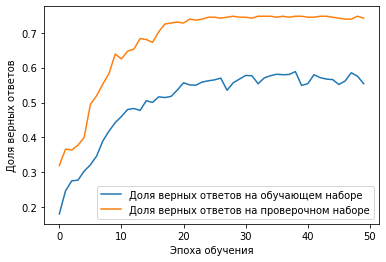

In [0]:
modelEL = Sequential() #создаём последовательную модель нейросети

#преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEL.add(Embedding(maxWordsCount, 50, input_length=xLen))

modelEL.add(SpatialDropout1D(0.4)) #добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEL.add(BatchNormalization()) #добавляем слой нормализации данных
modelEL.add(CuDNNLSTM(4)) #добавляем слой LSTM, совместимый с Cuda при поддержке GPU
modelEL.add(Dropout(0.5)) #добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEL.add(BatchNormalization()) #добавляем слой нормализации данных
modelEL.add(Dense(100, activation="relu")) #добавляем полносвязный слой с указанием количества нейронов и функции активации
modelEL.add(Dropout(0.5)) #добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEL.add(BatchNormalization()) #добавляем слой нормализации данных
modelEL.add(Dense(10, activation='softmax')) #добавляем полносвязный слой на 22 нейронов, с функцией активации softmax на выходном слое для 22 классов

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEL.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEL.fit(xTrainE, 
                    yTrainE, 
                    epochs=50,
                    batch_size=4,
                    validation_data=(xValE, yValE))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()


**Conv1D**

Train on 1437 samples, validate on 360 samples
Epoch 1/60
1437/1437 [==============================] - 3s 2ms/sample - loss: 1.9121 - acc: 0.3987 - val_loss: 1.5286 - val_acc: 0.6750
Epoch 2/60
1437/1437 [==============================] - 3s 2ms/sample - loss: 0.6226 - acc: 0.8149 - val_loss: 0.5073 - val_acc: 0.8444
Epoch 3/60
1437/1437 [==============================] - 3s 2ms/sample - loss: 0.4341 - acc: 0.8657 - val_loss: 0.4150 - val_acc: 0.8583
Epoch 4/60
1437/1437 [==============================] - 3s 2ms/sample - loss: 0.3216 - acc: 0.8963 - val_loss: 0.4076 - val_acc: 0.8750
Epoch 5/60
1437/1437 [==============================] - 3s 2ms/sample - loss: 0.2366 - acc: 0.9332 - val_loss: 0.3952 - val_acc: 0.8778
Epoch 6/60
1437/1437 [==============================] - 3s 2ms/sample - loss: 0.2027 - acc: 0.9353 - val_loss: 0.3908 - val_acc: 0.8917
Epoch 7/60
1437/1437 [==============================] - 3s 2ms/sample - loss: 0.1774 - acc: 0.9478 - val_loss: 0.4072 - val_acc: 0.8806
E

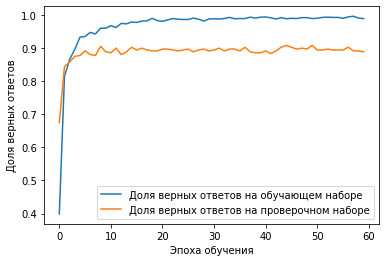

In [0]:
modelEC = Sequential() #создаём последовательную модель нейросети
#преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEC.add(Embedding(maxWordsCount, 50, input_length=xLen))

modelEC.add(SpatialDropout1D(0.2)) #добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEC.add(BatchNormalization()) #добавляем слой нормализации данных
modelEC.add(Conv1D(20, 5, activation="relu")) #добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
#modelEC.add(MaxPooling1D(2)) #добавляем слой подвыборки/пулинга с функцией максимума
modelEC.add(Conv1D(20, 5, activation="relu")) #добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
modelEC.add(MaxPooling1D(2)) #добавляем слой подвыборки/пулинга с функцией максимума
modelEC.add(Dropout(0.2)) #добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) #добавляем слой нормализации данных
modelEC.add(Flatten()) #добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
modelEC.add(Dense(10, activation='softmax')) #добавляем полносвязный слой на 22 нейронов, с функцией активации softmax на выходном слое для 22 классов

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEC.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEC.fit(xTrainE, 
                    yTrainE, 
                    epochs=60,
                    batch_size=4,
                    validation_data=(xValE, yValE))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

**LSTM + Conv1D**

Train on 1437 samples, validate on 360 samples
Epoch 1/30
1437/1437 [==============================] - 2s 1ms/sample - loss: 2.1659 - acc: 0.2387 - val_loss: 2.2686 - val_acc: 0.2056
Epoch 2/30
1437/1437 [==============================] - 0s 156us/sample - loss: 1.2098 - acc: 0.6298 - val_loss: 2.2501 - val_acc: 0.4333
Epoch 3/30
1437/1437 [==============================] - 0s 153us/sample - loss: 0.7751 - acc: 0.7787 - val_loss: 2.2410 - val_acc: 0.1750
Epoch 4/30
1437/1437 [==============================] - 0s 160us/sample - loss: 0.5856 - acc: 0.8295 - val_loss: 2.2272 - val_acc: 0.4361
Epoch 5/30
1437/1437 [==============================] - 0s 156us/sample - loss: 0.4610 - acc: 0.8580 - val_loss: 2.2247 - val_acc: 0.5194
Epoch 6/30
1437/1437 [==============================] - 0s 159us/sample - loss: 0.4080 - acc: 0.8789 - val_loss: 2.2200 - val_acc: 0.1583
Epoch 7/30
1437/1437 [==============================] - 0s 153us/sample - loss: 0.3209 - acc: 0.9033 - val_loss: 2.2265 - val_a

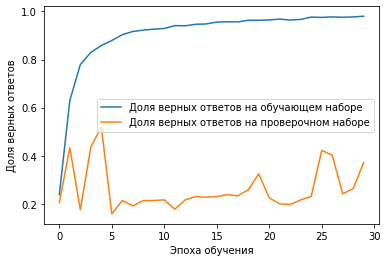

In [0]:
modelEC = Sequential() #создаём последовательную модель нейросети
#преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEC.add(Embedding(maxWordsCount, 50, input_length=xLen))

modelEC.add(SpatialDropout1D(0.2)) #добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEC.add(CuDNNLSTM(4, return_sequences=1)) #добавляем слой LSTM, совместимый с Cuda при поддержке GPU
modelEC.add(Dense(100, activation='relu')) #добавляем полносвязный слой с указанием количества нейронов и функции активации
modelEC.add(Conv1D(20, 5, activation="relu")) #добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
modelEC.add(CuDNNLSTM(4, return_sequences=1)) #добавляем слой LSTM, совместимый с Cuda при поддержке GPU
modelEC.add(Dropout(0.2)) #добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) #добавляем слой нормализации данных
modelEC.add(Conv1D(20, 5, activation="relu")) #добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
modelEC.add(Conv1D(20, 5, activation="relu")) #добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
modelEC.add(MaxPooling1D(2)) #добавляем слой подвыборки/пулинга с функцией максимума
modelEC.add(Dropout(0.2)) #добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) #добавляем слой нормализации данных
modelEC.add(Flatten()) #добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
modelEC.add(Dense(10, activation='softmax')) #добавляем полносвязный слой на 22 нейронов, с функцией активации softmax на выходном слое для 22 классов

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEC.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEC.fit(xTrainE, 
                    yTrainE, 
                    epochs=30,
                    batch_size=200,
                    validation_data=(xValE, yValE))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

###  Вывод по выбору архитектуры нейросети

- Embedding + Dense = val_acc: 0.9278

- LSTM + Dense  = val_acc: 0.7472

- Conv1D           = val_acc: 0.9083

- LSTM + Conv1D  = val_acc: 0.4028

Наибольшую точность показала архитектура Embedding + Dense 

# Проверка распознавания целикового сообщения

In [0]:
# Получаем один абзац для предсказания
num = 0

test_text     = df_all.iloc[num]['describe'] 
test_category = df_all.iloc[num]['category'] 
print(len(test_text))
print(test_text) 
print(test_category) 

69
Резкая боль в животе Повышение температуры Напряженность мышц Тошнота
Аппендицит


In [0]:
# Функция возвращающая ключ с максимальным заначением в словаре
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k
            break

def get_max_class(mas_pred):
  dict_pred = dict(Counter(mas_pred))
  max_val = max(dict_pred.values())
  max_class = get_key(dict_pred, max_val)
  return max_class


In [0]:
# Распознавание всей обучающей базы
right = 0
for num in range(df_all.shape[0]):
  # Получаем один абзац для предсказания
  test_text     = df_all.iloc[num]['describe'] 
  test_category = df_all.iloc[num]['category'] 
  
  if len(test_text) > 1:
    #преобразовываем текст в последовательность индексов согласно частотному словарю
    test_text_in_WordIndexes = tokenizer.texts_to_sequences([test_text])[0]
    
    # Делим абзац на отрезки
    test_split_text = split_message(test_text_in_WordIndexes, xLen, step)
    
    # Преобразование категории абзаца в номер класса категории
    test_class = encoder.transform([test_category])[0]
    
    # Распознавание класса отрезка
    currPred = modelE.predict([test_split_text])
    currOut = np.argmax(currPred, axis=1)
    curr_max_class = get_max_class(currOut)
    #print('Истинный класс', test_class)
    #print('Предсказанный ', curr_max_class)

    # Сравнение привильного класса сообщения с определенным классом для отрезка
    if test_class == curr_max_class:
      print(num, ' Длинна текста с симптомами = ',len(test_text), ' Распознано Верно - ', list_unic_classes[curr_max_class])      
      right += 1
    else: 
      print(num, ' Длинна текста с симптомами = ',len(test_text), ' Распознано Неверно', list_unic_classes[test_class] , ' распознан как ',list_unic_classes[curr_max_class])
print()
print('Всего проверено описаний симптомов - ', num)
print('Из них опреленно верно   - ', right, ' ', round(right*100/num,2), '%')
wrong = num - right
print('Из них опреленно неверно - ', wrong, ' ', round(wrong*100/num,2), '%')


0  Длинна текста с симптомами =  69  Распознано Верно -  Аппендицит
1  Длинна текста с симптомами =  88  Распознано Верно -  Аппендицит
2  Длинна текста с симптомами =  271  Распознано Верно -  Аппендицит
3  Длинна текста с симптомами =  166  Распознано Верно -  Аппендицит
4  Длинна текста с симптомами =  309  Распознано Верно -  Аппендицит
5  Длинна текста с симптомами =  73  Распознано Верно -  Аппендицит
6  Длинна текста с симптомами =  384  Распознано Верно -  Аппендицит
7  Длинна текста с симптомами =  76  Распознано Верно -  Аппендицит
8  Длинна текста с симптомами =  172  Распознано Верно -  Аппендицит
9  Длинна текста с симптомами =  239  Распознано Верно -  Аппендицит
10  Длинна текста с симптомами =  208  Распознано Неверно Аппендицит  распознан как  Эзофагит
11  Длинна текста с симптомами =  121  Распознано Верно -  Аппендицит
12  Длинна текста с симптомами =  163  Распознано Верно -  Аппендицит
13  Длинна текста с симптомами =  106  Распознано Верно -  Аппендицит
14  Длинна

## Вывод при подходе разбиения текста с описаниями симптомов на отрезки, обучения сети на этих отрезках с последующим предсказанием всего текста сообщения путем деления его на отрезки и подсчетом наибольшего количества класса в пресказаниях как класса к которому можно отнести все сообщение показывает хороший результат. 

# Удалось добиться точности предсказания по симптомам - 89%

# Conclusion when the approach of splitting the text with descriptions of symptoms into segments, training the network on these segments, followed by predicting the entire text of the message by dividing it into segments and counting the largest number of classes in the pretexts as a class to which the entire message can be attributed, shows a good result

# It was possible to achieve accurate prediction of symptoms-89%